In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# We need to join the upper directory in order to access the local modules
import datetime
import os
import pickle
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

import itertools
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

In [3]:
from pytdoa.pytdoa import nonlinoptim, linoptim
from pytdoa.geodesy.geodesy import SPEED_OF_LIGHT

from util import moving_average

In [4]:
plt.rcParams["font.family"] = "Linux Libertine O"
plt.rcParams["font.size"] = 20

In [5]:
# Reading the mat files
with open("comnets_data/gnbPositions.json") as gnb_file:
    data = json.load(gnb_file)

gNBs = np.array([data["gnb0"], data["gnb1"], data["gnb2"], data["gnb3"]])

with open("comnets_data/uePositions.json") as ue_file:
    data = json.load(ue_file)

UEs = np.array(
    [data["ue0"], data["ue1"], data["ue2"], data["ue3"], data["ue4"], data["ue5"]]
)

## Playing a bit with the observed TDOA values

In [6]:
# Main params
POSITION = 5
FREQUENCY_MHZ = 100  # MHz
FREQUENCY = FREQUENCY_MHZ * 1e6

# Reading and filtering
toa_measurements = pd.read_csv(
    f"comnets_data/experiments/exp{POSITION}/{FREQUENCY_MHZ}mhz.csv"
)
toa_measurements.drop(
    [
        "Unnamed: 0",
    ],
    axis=1,
    inplace=True,
)

if FREQUENCY_MHZ == 100:
    if POSITION == 4:
        toa_measurements = toa_measurements.drop(["gNB0", "P0"], axis=1)

    toa_filt = toa_measurements.loc[~((toa_measurements == float("-inf")).any(axis=1))]
    toa_filt.reset_index(drop=True, inplace=True)

    if POSITION == 1:
        toa_filt = toa_filt.loc[154:]  # Only for Position 1

elif FREQUENCY_MHZ == 40:
    if POSITION != 2:
        toa_measurements = toa_measurements.drop(["gNB0", "P0"], axis=1)
    else:
        toa_measurements = toa_measurements.drop(["gNB1", "P1"], axis=1)

    toa_filt = toa_measurements.loc[~((toa_measurements == float("-inf")).any(axis=1))]
    toa_filt.reset_index(drop=True, inplace=True)

else:
    raise RuntimeError("Not a supported frequency")
toa_filt.head(10)

,gNB0,P0,gNB1,P1,gNB2,P2,gNB3,P3
0,-15.0,-56.7,-15.0,-56.1,-13.0,-55.4,-14.0,-56.5
1,-11.0,-55.2,-11.0,-56.0,-10.0,-55.3,-11.0,-57.5
2,-10.0,-57.3,-11.0,-57.2,-10.0,-56.9,-11.0,-56.1
3,-5.0,-55.3,-5.0,-56.5,-4.0,-55.4,-5.0,-57.4
4,-4.0,-55.1,-3.0,-56.9,-1.0,-55.0,-2.0,-56.6
5,-1.0,-55.3,0.0,-56.7,1.0,-54.4,0.0,-57.0
6,-2.0,-54.4,-1.0,-58.2,1.0,-53.9,0.0,-56.6
7,2.0,-54.7,2.0,-56.9,4.0,-55.7,3.0,-56.4
8,3.0,-55.2,5.0,-56.9,6.0,-54.9,5.0,-57.0
9,3.0,-54.8,4.0,-58.3,6.0,-53.8,5.0,-56.0


In [7]:
# Calculating the theoretical values
th_toa = np.linalg.norm(UEs[POSITION] - gNBs, axis=1)
th_tdoa = (th_toa.reshape((-1, 1)) - th_toa)[np.triu_indices(4, k=1)]
th_tdoa

array([-2.04150136, -3.99966981, -2.49358953, -1.95816845, -0.45208817,
        1.50608028])

In [10]:
# Moving Average parameters
ma_window = 20

# Vectorized version to obtain TDOA values
toas = toa_filt[["gNB0", "gNB1", "gNB2", "gNB3"]].to_numpy()
triu_indices = np.triu_indices(4, k=1)
tdoas = (
    toas.reshape((toas.shape[0], toas.shape[1], 1))
    - toas.reshape((toas.shape[0], 1, toas.shape[1]))
)[:, triu_indices[0], triu_indices[1]]

# A bit of masking to remove obvious outliers
maskl, masku = (tdoas > -20), tdoas < 20
mask = (maskl & masku).all(axis=1)
tdoas = moving_average(tdoas[mask, :], ma_window)

tdoas = tdoas / FREQUENCY * SPEED_OF_LIGHT
tdoa_mean = np.mean(tdoas, axis=0)

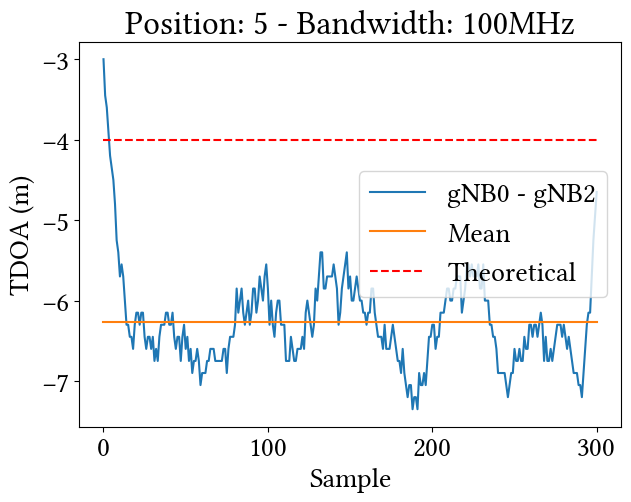

In [9]:
difference = 1
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(tdoas[:, difference])
ax.plot(tdoa_mean[difference] * np.ones(tdoas.shape[0]))
ax.plot(th_tdoa[difference] * np.ones(tdoas.shape[0]), linestyle="dashed", color="red")

ax.set_title(f"Position: {POSITION} - Bandwidth: {FREQUENCY_MHZ}MHz")
ax.set_xlabel("Sample")
ax.set_ylabel("TDOA (m)")
ax.legend(
    [
        f"gNB{triu_indices[0][difference]} - gNB{triu_indices[1][difference]}",
        "Mean",
        "Theoretical",
    ]
)

In [37]:
experiment = 100
combination_range = itertools.combinations(np.arange(len(gNBs)), 2)
combinations = np.fromiter(combination_range, dtype=np.dtype((int,2)))

In [38]:
linpos = linoptim(gNBs,tdoas[experiment,0:4],input_type='xyz').squeeze()
print(f"Calculated Position - x: {linpos[0]:.4f} y: {linpos[1]:.4f}")
print(f"Real Position - x: {UEs[POSITION,0]:.4f} y: {UEs[POSITION,1]:.4f}")

Calculated Position - x: 0.1907 y: 5.0905
Real Position - x: 5.2800 y: 7.6800


In [83]:
result = nonlinoptim(gNBs, tdoas[experiment,:], combinations, num_dim=2, p0=linpos, input_type="xyz", use_offset=True, l=.05)
print(f"Calculated Position - x: {result[0]:.4f} y: {result[1]:.4f}")
print(f"Offsets: gNB0 = {result[2]}, gNB1 = {result[3]}, gNB2 = {result[4]}, gNB3 = {result[5]}")

Calculated Position - x: 4.7256 y: 8.5511
Offsets: gNB0 = 8.266993309478607, gNB1 = -11.099348200217793, gNB2 = 16.66590755883821, gNB3 = -13.833552668099006


In [40]:
# Let's do some specific processing
o = np.zeros(4)
for i in range(tdoas.shape[0]):
    result = nonlinoptim(gNBs, tdoas[experiment,:], combinations, num_dim=2, p0=linpos, input_type="xyz", use_offset=True, l=.5)
    o += result[2:]

o /= tdoas.shape[0]

In [80]:
do = (o.reshape((-1, 1)) - o.reshape(1, -1))[triu_indices[0], triu_indices[1]]
tdoas_corrected = tdoas - do
tdoas_corrected_mean = np.mean(tdoas_corrected, axis=0)

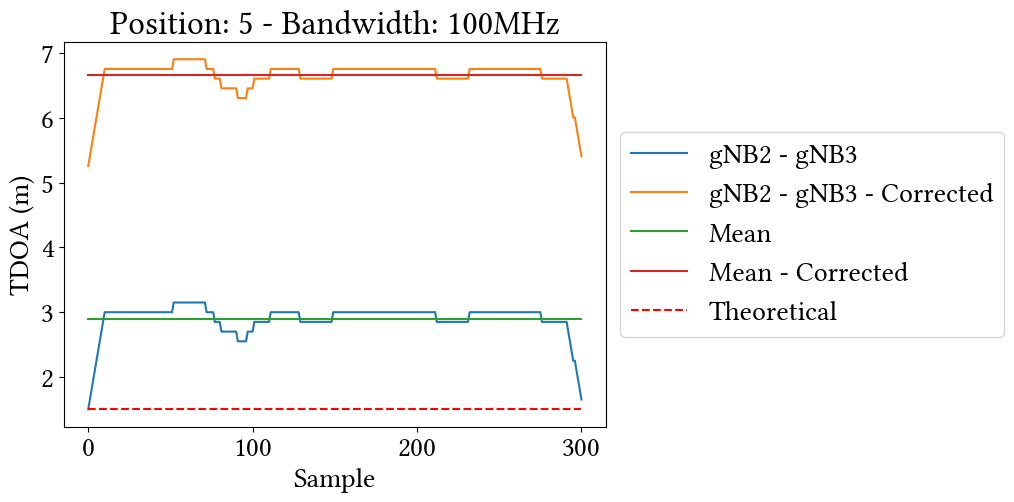

In [52]:
difference = 5
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(tdoas[:, difference])
ax.plot(tdoas_corrected[:, difference])
ax.plot(tdoa_mean[difference] * np.ones(tdoas.shape[0]))
ax.plot(tdoas_corrected_mean[difference] * np.ones(tdoas_corrected.shape[0]))
ax.plot(th_tdoa[difference] * np.ones(tdoas_corrected.shape[0]), linestyle="dashed", color="red")

ax.set_title(f"Position: {POSITION} - Bandwidth: {FREQUENCY_MHZ}MHz")
ax.set_xlabel("Sample")
ax.set_ylabel("TDOA (m)")
ax.legend(
    [
        f"gNB{triu_indices[0][difference]} - gNB{triu_indices[1][difference]}",
        f"gNB{triu_indices[0][difference]} - gNB{triu_indices[1][difference]} - Corrected",
        "Mean",
        "Mean - Corrected",
        "Theoretical",
    ],
    loc="center left", 
    bbox_to_anchor=(1, 0.5),
)

plt.show()

## Let's get this for all positions

In [7]:
# Let's analyze one frequency at a time
frequency_mhz = 100  # MHz
frequency = frequency_mhz * 1e6
ma_window = 10

result_dict = {}

result_dict["ma"] = ma_window
result_dict["frequency"] = frequency
result_dict["frequency_mhz"] = frequency_mhz
for position in range(0, 6):
    # Reading and filtering
    df = pd.read_csv(f"comnets_data/experiments/exp{position}/{frequency_mhz}mhz.csv")
    df.drop(
        [
            "Unnamed: 0",
        ],
        axis=1,
        inplace=True,
    )

    # Setting the stage
    n = 4  # We will use 4 gNBs except for position 4

    # This is internal knowledge
    if frequency_mhz == 100:
        if position == 4:
            df.drop(["gNB0", "P0"], axis=1, inplace=True)
            n = 3

        df_filt = df.loc[~((df == float("-inf")).any(axis=1))]
        df_filt.reset_index(drop=True, inplace=True)

        if position == 1:
            df_filt = df_filt.loc[154:]  # Only for Position 1

    elif frequency_mhz == 40:
        if position != 2:
            df.drop(["gNB0", "P0"], axis=1, inplace=True)
        else:
            df.drop(["gNB1", "P1"], axis=1, inplace=True)

        df_filt = df.loc[~((toa_measurements == float("-inf")).any(axis=1))]
        df_filt.reset_index(drop=True, inplace=True)
    
    else:
        raise RuntimeError("Unsupported frequency")

    # Calculating the theoretical values
    th_toa = np.linalg.norm(UEs[position] - gNBs, axis=1)
    th_tdoa = (th_toa.reshape((-1, 1)) - th_toa)[np.triu_indices(n, k=1)]
    result_dict[f"P{position}", "th_tdoa"] = th_tdoa

    # Vectorized version to obtain TDOA values
    if position == 4:
        toas = df_filt[["gNB1", "gNB2", "gNB3"]].to_numpy()
    else:
        toas = df_filt[["gNB0", "gNB1", "gNB2", "gNB3"]].to_numpy()
    triu_indices = np.triu_indices(n, k=1)
    tdoas = (
        toas.reshape((toas.shape[0], toas.shape[1], 1))
        - toas.reshape((toas.shape[0], 1, toas.shape[1]))
    )[:, triu_indices[0], triu_indices[1]]

    # A bit of masking to remove obvious outliers
    maskl, masku = (tdoas > -30), tdoas < 30
    mask = (maskl & masku).all(axis=1)
    tdoas = moving_average(tdoas[mask, :], ma_window)

    tdoas = tdoas / frequency * SPEED_OF_LIGHT
    tdoas_mean = np.mean(tdoas, axis=0)

    # Let's store our precious data
    result_dict[f"P{position}", "tdoas"] = tdoas
    result_dict[f"P{position}", "tdoas_mean"] = tdoas_mean

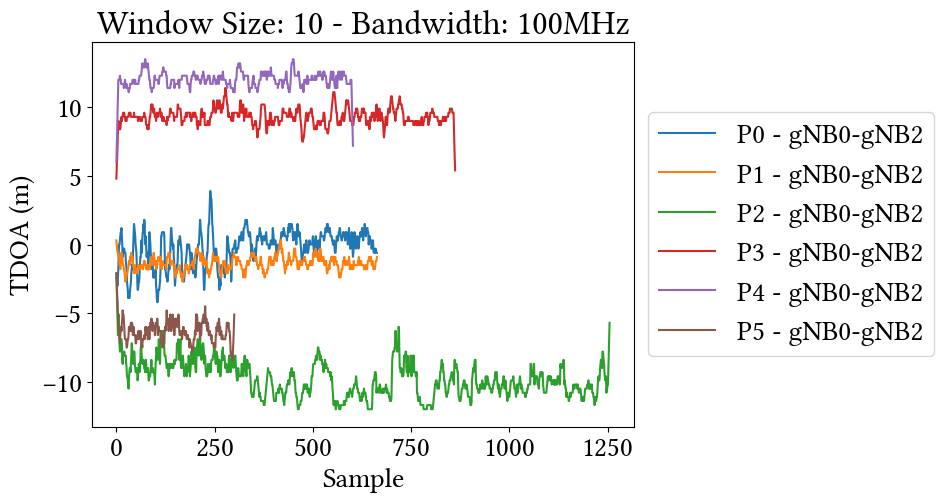

In [10]:
difference = 1

fig, ax = plt.subplots(figsize=(7, 5))

for i in range(0, 6):
    if i == 4 and difference > 2:
        continue
    td = result_dict[f"P{i}", "tdoas"]
    ax.plot(
        td[:, difference],
        label=f"P{i} - gNB{triu_indices[0][difference]}-gNB{triu_indices[1][difference]}",
    )

ax.set_title(f'Window Size: {result_dict["ma"]} - Bandwidth: {frequency_mhz}MHz')
ax.set_xlabel("Sample")
ax.set_ylabel("TDOA (m)")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

## Positioning results for all positions

In [164]:
# Let's analyze one frequency at a time
frequency_mhz = 100  # MHz
frequency = frequency_mhz * 1e6
ma_window = 20
offset = True
lr = 0.4
ngnb = 4

result_dict = {}

result_dict["ma"] = ma_window
result_dict["frequency"] = frequency
result_dict["frequency_mhz"] = frequency_mhz
result_dict["offset"] = offset
result_dict["lr"] = lr
n = 4  # We will use 4 gNBs except for position 4 & 40 MHz examples
for position in range(0, 6):
    # Reading and filtering
    df = pd.read_csv(f"comnets_data/experiments/exp{position}/{frequency_mhz}mhz.csv")
    df.drop(
        [
            "Unnamed: 0",
        ],
        axis=1,
        inplace=True,
    )

    # This is internal knowledge
    if frequency_mhz == 100:
        if ngnb == 4:
            if position == 4:
                df.drop(["gNB0", "P0"], axis=1, inplace=True)
                n = 3
                gnbs = gNBs[1:, :]
            else:
                gnbs = gNBs
        else:
            df.drop(["gNB0", "P0"], axis=1, inplace=True)
            n = 3
            gnbs = gNBs[1:]

        df_filt = df.loc[~((df == float("-inf")).any(axis=1))]
        df_filt.reset_index(drop=True, inplace=True)

        if position == 1:
            df_filt = df_filt.loc[154:]  # Only for Position 1

    elif frequency_mhz == 40:
        n = 3

        if position != 2:
            df.drop(["gNB0", "P0"], axis=1, inplace=True)
            gnbs = gNBs[1:, :]
        else:
            df.drop(["gNB1", "P1"], axis=1, inplace=True)
            gnbs = gNBs[[0, 2, 3], :]

        df_filt = df.loc[~((df == float("-inf")).any(axis=1))]
        df_filt.reset_index(drop=True, inplace=True)

    else:
        raise RuntimeError("Unsupported frequency")

    # Calculating the theoretical values
    th_toa = np.linalg.norm(UEs[position] - gnbs, axis=1)
    th_tdoa = (th_toa.reshape((-1, 1)) - th_toa)[np.triu_indices(n, k=1)]
    result_dict[f"P{position}", "th_tdoa"] = th_tdoa

    # Vectorized version to obtain TDOA values
    if frequency_mhz == 100:
        if ngnb == 4:
            if position == 4:
                toas = df_filt[["gNB1", "gNB2", "gNB3"]].to_numpy()
            else:
                toas = df_filt[["gNB0", "gNB1", "gNB2", "gNB3"]].to_numpy()
        else:
            toas = df_filt[["gNB1", "gNB2", "gNB3"]].to_numpy()
    elif frequency_mhz == 40:
        if position == 1:
            continue
        elif position != 2:
            toas = df_filt[["gNB1", "gNB2", "gNB3"]].to_numpy()
        else:
            toas = df_filt[["gNB0", "gNB2", "gNB3"]].to_numpy()
    else:
        raise RuntimeError("Unsupported frequency")

    triu_indices = np.triu_indices(n, k=1)
    tdoas = (
        toas.reshape((toas.shape[0], toas.shape[1], 1))
        - toas.reshape((toas.shape[0], 1, toas.shape[1]))
    )[:, triu_indices[0], triu_indices[1]]

    # A bit of masking to remove obvious outliers
    maskl, masku = (tdoas > -7), tdoas < 7
    mask = (maskl & masku).all(axis=1)
    tdoas = moving_average(tdoas[mask, :], ma_window)

    tdoas = tdoas / frequency * SPEED_OF_LIGHT
    tdoas_mean = np.mean(tdoas, axis=0)

    # Let's start the positioning routines
    combination_range = itertools.combinations(np.arange(len(gnbs)), 2)
    combinations = np.fromiter(combination_range, dtype=np.dtype((int, 2)))

    linear = []
    nonlin = []
    for experiment in range(len(tdoas)):
        linpos = linoptim(gNBs, tdoas[experiment, 0:n], input_type="xyz").squeeze()
        result = nonlinoptim(
            gNBs,
            tdoas[experiment, :],
            combinations,
            num_dim=2,
            p0=linpos,
            input_type="xyz",
            use_offset=offset,
            l=lr,
        )

        linear.append(linpos)
        nonlin.append(result)
    
    result_dict[f'P{position}','linear'] = np.array(linear)
    result_dict[f'P{position}','nonlin'] = np.array(nonlin)
    print(f"Finished P{position} - Processed {len(tdoas)} points.")

now = round(datetime.datetime.now().timestamp())
with open(f'comnets_data/results/experiments/{n}_{frequency_mhz}mhz_window_{ma_window}_offset_{offset}_lr_{round(lr*100)}.pickle', 'wb') as handle:
    pickle.dump(result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

Finished P0 - Processed 664 points.
Finished P1 - Processed 664 points.
Finished P2 - Processed 1256 points.
Finished P3 - Processed 862 points.
Finished P4 - Processed 579 points.
Finished P5 - Processed 301 points.


## Processing the results

In [170]:
import pickle
frequency_mhz = 100

In [171]:
if frequency_mhz == 100:
    with open('comnets_data/results/experiments/4_100mhz_window_5_offset_False_lr_40.pickle', 'rb') as p:
        data_no_offset = pickle.load(p)

    with open('comnets_data/results/experiments/4_100mhz_window_5_offset_True_lr_40.pickle', 'rb') as p:
        data_wt_offset = pickle.load(p)
else:
    with open('comnets_data/results/experiments/3_40mhz_window_10_offset_False_lr_40.pickle', 'rb') as p:
        data_no_offset = pickle.load(p)

    with open('comnets_data/results/experiments/3_40mhz_window_10_offset_True_lr_40.pickle', 'rb') as p:
        data_wt_offset = pickle.load(p)

In [172]:
eelin = np.array([])
eenli = np.array([])

eelin_o = np.array([])
eenli_o = np.array([])

for i in range(UEs.shape[0]):
    if frequency_mhz == 40 and i == 1:
        continue
    ue = UEs[i]
    lin = data_no_offset[f'P{i}','linear']
    nli = data_no_offset[f'P{i}','nonlin']

    lin_o = data_wt_offset[f'P{i}','linear']
    nli_o = data_wt_offset[f'P{i}','nonlin'][:,0:2]

    elin = np.linalg.norm(ue-lin,axis=1)
    enli = np.linalg.norm(ue-nli,axis=1)
    elin_o = np.linalg.norm(ue-lin_o,axis=1)
    enli_o = np.linalg.norm(ue-nli_o,axis=1)

    eelin = np.append(eelin, elin)
    eenli = np.append(eenli, enli)
    eelin_o = np.append(eelin_o, elin_o)
    eenli_o = np.append(eenli_o, enli_o)

eelin = eelin[eelin < 1000]
eenli = eenli[eenli < 1000]

eelin_o = eelin_o[eelin_o < 1000]
eenli_o = eenli_o[eenli_o < 1000]

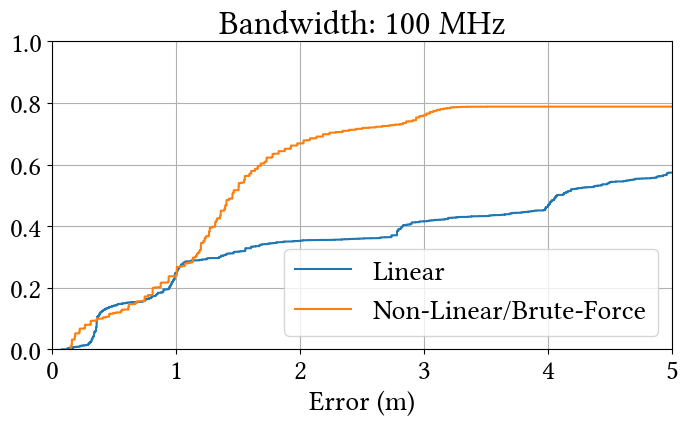

In [173]:
f, ax = plt.subplots(figsize=(8, 4))

ax.ecdf(eelin)
ax.ecdf(eenli)

ax.set_xlim([0,5])
ax.grid()

ax.set_title(f'Bandwidth: {frequency_mhz} MHz')
ax.set_xlabel('Error (m)')
ax.legend(['Linear', 'Non-Linear/Brute-Force'])

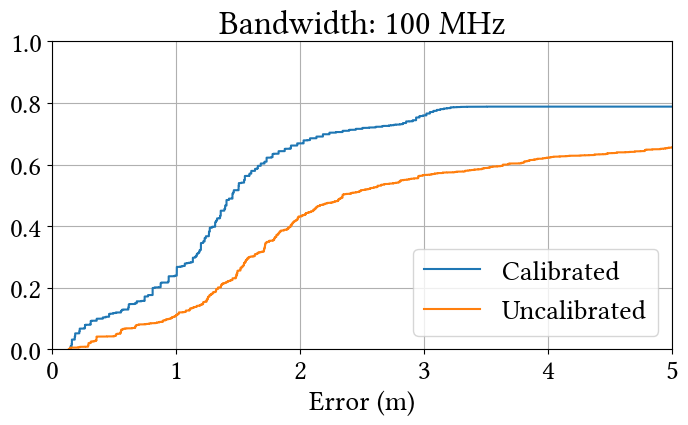

In [175]:
f, ax = plt.subplots(figsize=(8, 4))

ax.ecdf(eenli)
ax.ecdf(eenli_o)

ax.set_xlim([0,5])
ax.grid()

ax.set_title(f'Bandwidth: {frequency_mhz} MHz')
ax.set_xlabel('Error (m)')
ax.legend(['Calibrated', 'Uncalibrated'])

(3412,)